In [1]:
from kafka import KafkaConsumer
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
def changing_sld_values(df):
    sld_confidences = []    
    for sld in df['sld']:
        if sld in sld_conf_dict:
            sld_confidences.append(sld_conf_dict[sld])
        else:
            sld_confidences.append(5)
            
    df['sld_confidence'] = sld_confidences
    
    return df.drop(columns= ['sld'])

In [4]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)
count = 0
window_number = 0
window = [] 
column_names = []
f1_scores = []

with open('features_to_exclude.pickle', 'rb') as handle:
    features_to_exclude = pickle.load(handle)
        
with open('slds_confidence.pickle', 'rb') as handle:
    sld_conf_dict = pickle.load(handle)
    
with open('scaler.pickle', 'rb') as handle:
    scaler = pickle.load(handle)
    
with open('model.pkl', 'rb') as handle:
    dynamic_model = pickle.load(handle)
    
dynamic_model.set_params(warm_start=True)    
            
        
for m in consumer:
    data=m.value.decode('utf-8').strip("\"").strip("\\n").split(",")
    if 'FQDN_count' in data and window_number == 0:
        column_names = data
    else:
        count += 1
        window.append(data)
        
    if count == 1000:
        count = 0
        window_number += 1
            
        df = pd.DataFrame(window, columns = column_names)
        #preprocessing - taking care of sld values
        new_df = changing_sld_values(df)
        
        #droping missing values
        new_df = new_df.dropna(axis=0)
        
        #droping necessary features based on analysis on the 
        features_to_exclude.append(new_df.columns[0])
        window_df = new_df.drop(columns = features_to_exclude)
        
        X = window_df.drop(columns = ['Target Attack'])
        X = X.values.astype(np.float)
        y = window_df['Target Attack']
        y = y.values.astype(np.int) 
        scaler.transform(X)
        
        predictions = dynamic_model.predict(X)
        f1 = f1_score(y, predictions)
        f1_scores.append(f1)
        # if f1 < 0.86:
        #     dynamic_model.fit(X, y)
        #     predictions = dynamic_model.predict(X)
        #     f1 = f1_score(y, predictions)  
        #     print('retraining..')
            
        if window_number == 268:
            break
        

NoBrokersAvailable: NoBrokersAvailable

In [33]:
min(f1_scores)

0.8554991539763113

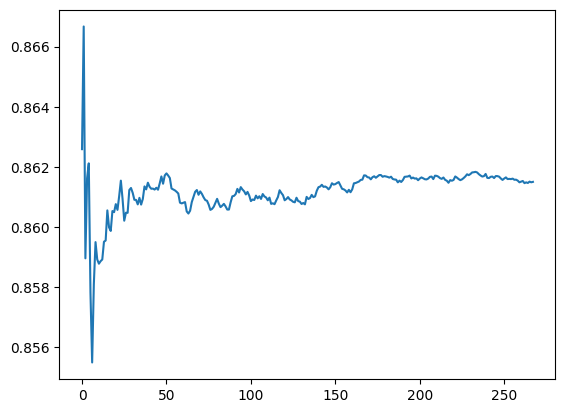

In [36]:
plt.plot(f1_scores) 